In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
import cv2
from tqdm import tqdm

# ==========================
# Dataset Loader
# ==========================
class CASIA2Dataset(Dataset):
    """Loads images from CASIA2 dataset (Au - Authentic, Tp - Tampered)."""
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load Au (Authentic) images with label 0
        au_path = os.path.join(root_dir, "Au")
        for img in os.listdir(au_path):
            if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
                self.image_paths.append(os.path.join(au_path, img))
                self.labels.append(0)  # Authentic

        # Load Tp (Tampered) images with label 1
        tp_path = os.path.join(root_dir, "Tp")
        for img in os.listdir(tp_path):
            if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
                self.image_paths.append(os.path.join(tp_path, img))
                self.labels.append(1)  # Tampered

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# ==========================
# Model Architecture (ResNet50 with Attention)
# ==========================
class AttentionBlock(nn.Module):
    """Self-Attention to highlight suspicious regions."""
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()
        proj_query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)
        proj_key = self.key(x).view(batch_size, -1, H * W)
        attention = F.softmax(torch.bmm(proj_query, proj_key), dim=-1)
        proj_value = self.value(x).view(batch_size, -1, H * W)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1)).view(batch_size, C, H, W)
        return self.gamma * out + x

class ForgeryDetector(nn.Module):
    """Enhanced ResNet50 for Image Forgery Detection."""
    def __init__(self, num_classes=2, pretrained=True):
        super(ForgeryDetector, self).__init__()
        resnet = models.resnet50(pretrained=pretrained)

        # Use pre-trained ResNet50 layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # Add attention layers
        self.attn1 = AttentionBlock(256)  # After layer1
        self.attn2 = AttentionBlock(512)  # After layer2
        self.attn3 = AttentionBlock(1024) # After layer3

        # Fully connected layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.attn1(x)

        x = self.layer2(x)
        x = self.attn2(x)

        x = self.layer3(x)
        x = self.attn3(x)

        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# ==========================
# Train Function
# ==========================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_forgery_detector.pth')
            print(f'Model Saved! Best Accuracy: {best_acc:.4f}')

# ==========================
# Main Training Script
# ==========================
if __name__ == '__main__':
    # Data transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Dataset and DataLoader
    dataset_path = "/kaggle/input/casia2-dataset/CASIA2 Dataset"  # Replace with CASIA2 path
    train_dataset = CASIA2Dataset(dataset_path, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # Model, Loss, Optimizer
    model = ForgeryDetector(num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Train the model
    train_model(model, train_loader, train_loader, criterion, optimizer, num_epochs=30)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


Epoch 1/30


100%|██████████| 789/789 [05:38<00:00,  2.33it/s]


Train Loss: 0.5251 Acc: 0.7390
Val Loss: 0.4119 Acc: 0.8041
Model Saved! Best Accuracy: 0.8041
Epoch 2/30


100%|██████████| 789/789 [04:29<00:00,  2.93it/s]


Train Loss: 0.4545 Acc: 0.7824
Val Loss: 0.4373 Acc: 0.8064
Model Saved! Best Accuracy: 0.8064
Epoch 3/30


100%|██████████| 789/789 [04:26<00:00,  2.96it/s]


Train Loss: 0.4159 Acc: 0.8064
Val Loss: 0.4128 Acc: 0.8103
Model Saved! Best Accuracy: 0.8103
Epoch 4/30


100%|██████████| 789/789 [04:24<00:00,  2.98it/s]


Train Loss: 0.3927 Acc: 0.8184
Val Loss: 0.3484 Acc: 0.8383
Model Saved! Best Accuracy: 0.8383
Epoch 5/30


100%|██████████| 789/789 [04:26<00:00,  2.96it/s]


Train Loss: 0.3748 Acc: 0.8243
Val Loss: 0.3495 Acc: 0.8343
Epoch 6/30


100%|██████████| 789/789 [04:25<00:00,  2.97it/s]


Train Loss: 0.3536 Acc: 0.8364
Val Loss: 0.2931 Acc: 0.8681
Model Saved! Best Accuracy: 0.8681
Epoch 7/30


100%|█████████▉| 788/789 [04:25<00:00,  2.98it/s]

Val Loss: 0.3065 Acc: 0.8557
Epoch 8/30


100%|██████████| 789/789 [04:27<00:00,  2.95it/s]


Train Loss: 0.3326 Acc: 0.8447
Val Loss: 0.2681 Acc: 0.8749
Model Saved! Best Accuracy: 0.8749
Epoch 9/30


100%|██████████| 789/789 [04:27<00:00,  2.95it/s]


Train Loss: 0.3168 Acc: 0.8502
Val Loss: 0.2632 Acc: 0.8780
Model Saved! Best Accuracy: 0.8780
Epoch 10/30


100%|██████████| 789/789 [04:29<00:00,  2.93it/s]


Train Loss: 0.3034 Acc: 0.8576
Val Loss: 0.2640 Acc: 0.8736
Epoch 11/30


100%|██████████| 789/789 [04:30<00:00,  2.91it/s]


Train Loss: 0.2961 Acc: 0.8599
Val Loss: 0.2703 Acc: 0.8690
Epoch 12/30


100%|██████████| 789/789 [04:30<00:00,  2.91it/s]


Train Loss: 0.2897 Acc: 0.8626
Val Loss: 0.2445 Acc: 0.8871
Model Saved! Best Accuracy: 0.8871
Epoch 13/30


100%|██████████| 789/789 [04:30<00:00,  2.92it/s]


Train Loss: 0.2824 Acc: 0.8671
Val Loss: 0.2531 Acc: 0.8816
Epoch 14/30


100%|██████████| 789/789 [04:29<00:00,  2.93it/s]


Train Loss: 0.2738 Acc: 0.8682
Val Loss: 0.2417 Acc: 0.8835
Epoch 15/30


100%|██████████| 789/789 [04:28<00:00,  2.94it/s]


Train Loss: 0.2704 Acc: 0.8737
Val Loss: 0.2363 Acc: 0.8833
Epoch 16/30


100%|██████████| 789/789 [04:28<00:00,  2.94it/s]


Train Loss: 0.2638 Acc: 0.8732
Val Loss: 0.2315 Acc: 0.8879
Model Saved! Best Accuracy: 0.8879
Epoch 17/30


100%|██████████| 789/789 [04:29<00:00,  2.93it/s]


Train Loss: 0.2545 Acc: 0.8785
Val Loss: 0.2436 Acc: 0.8847
Epoch 18/30


100%|██████████| 789/789 [04:29<00:00,  2.93it/s]


Train Loss: 0.2520 Acc: 0.8789
Val Loss: 0.2355 Acc: 0.8864
Epoch 19/30


100%|██████████| 789/789 [04:28<00:00,  2.94it/s]


Train Loss: 0.2478 Acc: 0.8801
Val Loss: 0.3854 Acc: 0.8304
Epoch 20/30


100%|██████████| 789/789 [04:28<00:00,  2.94it/s]


Train Loss: 0.2367 Acc: 0.8862
Val Loss: 0.2128 Acc: 0.8962
Model Saved! Best Accuracy: 0.8962
Epoch 21/30


100%|██████████| 789/789 [04:27<00:00,  2.94it/s]


Train Loss: 0.2407 Acc: 0.8845
Val Loss: 0.2012 Acc: 0.9031
Model Saved! Best Accuracy: 0.9031
Epoch 22/30


100%|██████████| 789/789 [04:28<00:00,  2.94it/s]


Train Loss: 0.2357 Acc: 0.8893
Val Loss: 0.2069 Acc: 0.9003
Epoch 23/30


100%|██████████| 789/789 [04:28<00:00,  2.94it/s]


Train Loss: 0.2315 Acc: 0.8883
Val Loss: 0.2335 Acc: 0.8905
Epoch 24/30


100%|██████████| 789/789 [04:28<00:00,  2.94it/s]


Train Loss: 0.2318 Acc: 0.8895
Val Loss: 0.3249 Acc: 0.8486
Epoch 25/30


100%|██████████| 789/789 [04:29<00:00,  2.93it/s]


Train Loss: 0.2233 Acc: 0.8940
Val Loss: 0.1998 Acc: 0.9016
Epoch 26/30


100%|██████████| 789/789 [04:29<00:00,  2.92it/s]


Train Loss: 0.2237 Acc: 0.8918
Val Loss: 0.1948 Acc: 0.9065
Model Saved! Best Accuracy: 0.9065
Epoch 27/30


100%|██████████| 789/789 [04:31<00:00,  2.91it/s]


Train Loss: 0.2205 Acc: 0.8934
Val Loss: 0.1889 Acc: 0.9068
Model Saved! Best Accuracy: 0.9068
Epoch 28/30


100%|██████████| 789/789 [04:29<00:00,  2.93it/s]


Train Loss: 0.2199 Acc: 0.8896
Val Loss: 0.1837 Acc: 0.9104
Model Saved! Best Accuracy: 0.9104
Epoch 29/30


100%|██████████| 789/789 [04:29<00:00,  2.92it/s]


Train Loss: 0.2205 Acc: 0.8937
Val Loss: 0.2033 Acc: 0.9013
Epoch 30/30


100%|██████████| 789/789 [04:31<00:00,  2.91it/s]


Train Loss: 0.2084 Acc: 0.8988
Val Loss: 0.2330 Acc: 0.8877


In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
from tqdm import tqdm

# Load trained model
model = ForgeryDetector(num_classes=2)
model.load_state_dict(torch.load("best_forgery_detector.pth"))  # Ensure correct path
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Data transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Test dataset loader
class TestCASIA2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        au_path = os.path.join(root_dir, "Au")
        for img in os.listdir(au_path):
            if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
                self.image_paths.append(os.path.join(au_path, img))
                self.labels.append(0)

        tp_path = os.path.join(root_dir, "Tp")
        for img in os.listdir(tp_path):
            if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
                self.image_paths.append(os.path.join(tp_path, img))
                self.labels.append(1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define test dataset path
test_dataset_path = "/kaggle/input/casia2-dataset/CASIA2 Dataset"  # Update path
test_dataset = TestCASIA2Dataset(test_dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")



<ipython-input-2-99e6bdb6689c>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_forgery_detector.pth"))  # Ensure correct path
100%|█

Test Accuracy: 91.51%


100%|██████████| 789/789 [02:02<00:00,  6.45it/s]


Confusion Matrix:
[[6592  899]
 [ 172 4951]]


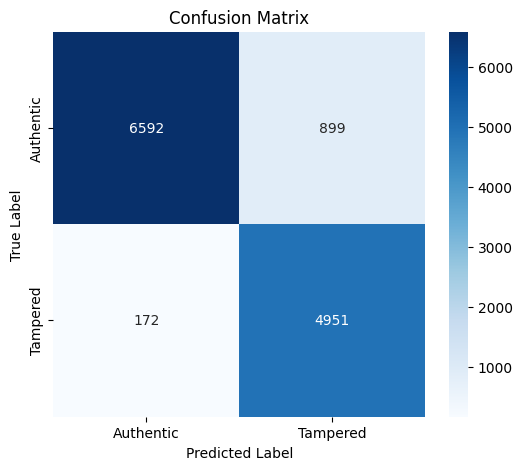

Classification Report:
              precision    recall  f1-score   support

   Authentic       0.97      0.88      0.92      7491
    Tampered       0.85      0.97      0.90      5123

    accuracy                           0.92     12614
   macro avg       0.91      0.92      0.91     12614
weighted avg       0.92      0.92      0.92     12614



In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Evaluate the model
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
# Compute Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Authentic", "Tampered"], yticklabels=["Authentic", "Tampered"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
class_report = classification_report(all_labels, all_preds, target_names=["Authentic", "Tampered"])
print("Classification Report:")
print(class_report)